Importar librerias

In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Cargar Datos

In [16]:
# Importamos la librería de pandas
import pandas as pd
import matplotlib as plt

In [17]:
# Si nuestro archivo csv que estamos leyendo esta separado por comas
df_train = pd.read_csv("./.././Entrenamiento.csv", encoding='utf-8', index_col = 0, usecols = [0,3,4,5,6,7,8,9,10,11])
df_train.head()


,RSSI,Ang_azimuth,Ang_elevacion,Canal,"LOS(si=1,no=0)",Altura_ant(cm),Distancia_entre_ant_tag(cm),Altura_tag(cm),Error_dato_medido
0,-60,-9,-12,37,1.0,134,30,130,0.0
1,-60,-8,-6,37,1.0,134,30,130,0.0
2,-56,-9,-12,38,1.0,134,30,130,0.0
3,-63,-9,-12,37,1.0,134,30,130,0.0
4,-59,-8,-6,37,1.0,134,30,130,0.0


Preparación de los datos

In [22]:
import numpy as np

# Se crea una copia de los datos para evitar posibles errores en los datos originales
df_features = df_train.copy()

# Se extrae la variable que queremos pronosticar
df_labels = df_features.pop("LOS(si=1,no=0)")
df_labels = df_features.pop("Canal")
df_labels = df_features.pop("Error_dato_medido")
df_features

,RSSI,Ang_azimuth,Ang_elevacion,Altura_ant(cm),Distancia_entre_ant_tag(cm),Altura_tag(cm)
0,-60,-9,-12,134,30,130
1,-60,-8,-6,134,30,130
2,-56,-9,-12,134,30,130
3,-63,-9,-12,134,30,130
4,-59,-8,-6,134,30,130
...,...,...,...,...,...,...
22555,-74,-2,-47,134,80,100
22556,-59,-2,-47,134,80,100
22557,-58,-2,-47,134,80,100
22558,-52,-2,-47,134,80,100


In [23]:
df_features.info()
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20754 entries, 0 to 22559
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   RSSI                         20754 non-null  int64
 1   Ang_azimuth                  20754 non-null  int64
 2   Ang_elevacion                20754 non-null  int64
 3   Altura_ant(cm)               20754 non-null  int64
 4   Distancia_entre_ant_tag(cm)  20754 non-null  int64
 5   Altura_tag(cm)               20754 non-null  int64
dtypes: int64(6)
memory usage: 1.1 MB
<class 'pandas.core.series.Series'>
Int64Index: 20754 entries, 0 to 22559
Series name: Error_dato_medido
Non-Null Count  Dtype  
--------------  -----  
20754 non-null  float64
dtypes: float64(1)
memory usage: 324.3 KB


In [21]:
df_features['Canal'] = df_features['Canal'].astype('int64')

ValueError: invalid literal for int() with base 10: '3-22'

In [24]:
df_labels

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
22555    1.0
22556    1.0
22557    1.0
22558    1.0
22559    1.0
Name: Error_dato_medido, Length: 20754, dtype: float64

Creación y entrenamiento del modelo

In [31]:
regresion_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(1),
    ]
)

regresion_model.compile(
    loss = tf.losses.MeanSquaredError(),
    optimizer = tf.optimizers.Adam(0.1)
)

history = regresion_model.fit(
    df_features,
    df_labels,
    epochs = 1000,
    verbose = False
)

Modelo entrenado!!!


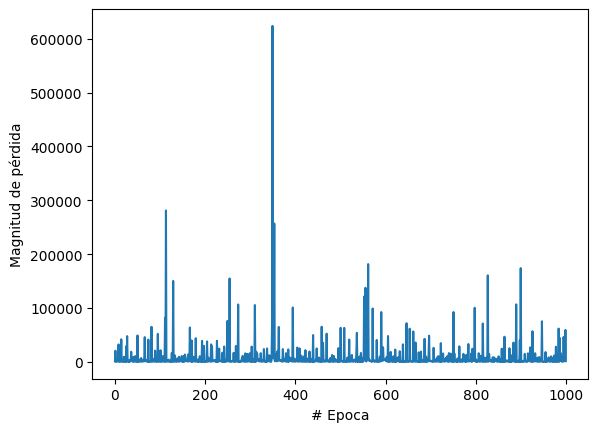

In [32]:
print("Modelo entrenado!!!")

import matplotlib.pyplot as plt
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history["loss"])

Prediciones

In [33]:
print("Haciendo una predicción!!!")
# 10024,2022/09/23/ 17:24:17,:CCF957966B2C,-65,9,-50,38,0.0,134,50,100,1.0
resultado = regresion_model.predict([-65,9,-50,134,50,100])

Haciendo una predicción!!!


ValueError: in user code:

    File "c:\Users\Jochan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Jochan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Jochan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Jochan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Jochan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Jochan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_5" "                 f"(type Sequential).
    
    Input 0 of layer "dense_10" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential_5" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int32)
      • training=False
      • mask=None


In [28]:
regresion_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                448       
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
649/649 [==============================] - 1s 1ms/step - loss: 1679.9869
Epoch 2/500
649/649 [==============================] - 1s 1ms/step - loss: 123044.3125
Epoch 3/500
649/649 [==============================] - 1s 1ms/step - loss: 291.6290
Epoch 4/500
649/649 [==============================] - 1s 1ms/step - loss: 102.9346
Epoch 5/500
649/649 [==============================] - 1s 1ms/step - loss: 101234.1641
Epoch 6/500
649/649 [==============================] - 1s 1ms/step - loss: 138.7739
Epoch 7/500
649/649 [==============================] - 1s 1ms/step - loss: 2721.1340
Epoch 8/500
649/649 [==============================] - 1s 1ms/step - loss: 2195.1931
Epoch 9/500
649/649 [==============================] - 1s 1ms/step - loss: 2088.2197
Epoch 10/500
649/649 [==============================] - 1s 1ms/step - loss: 617.9788
Epoch 11/500
649/649 [==============================] - 1s 1ms/step - loss: 99.2552
Epoch 12/500
649/649 [==============================] - 1s 1ms/st

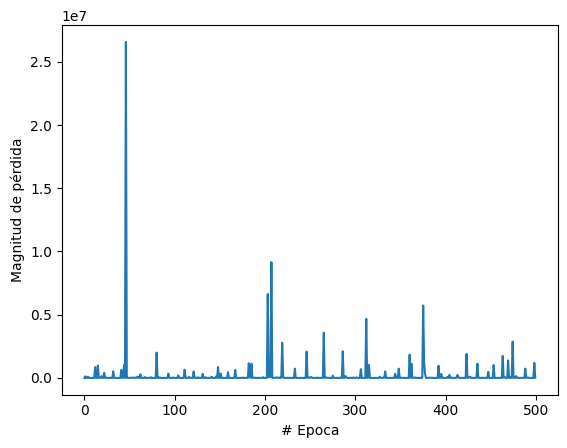

In [37]:
# otra red neuronal

oculta1 = tf.keras.layers.Dense(units = 64, input_shape = [6])
oculta2 = tf.keras.layers.Dense(units = 64)
salida = tf.keras.layers.Dense(units = 1)
modelo_regresion_2 = tf.keras.Sequential([oculta1, oculta2, salida])

modelo_regresion_2.compile(
    loss = tf.losses.MeanSquaredError(),
    optimizer = tf.optimizers.Adam(0.05)
)

history = modelo_regresion_2.fit(
    df_features,
    df_labels,
    epochs = 500,
    #verbose = False
)

print("Modelo entrenado!!!")

import matplotlib.pyplot as plt
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history["loss"])